## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('application_train.csv')
#data.count()

In [3]:
object_columns = data.select_dtypes(include='object').columns
int_columns = data.select_dtypes(include='int').columns
float_columns = data.select_dtypes(include='float').columns

data[object_columns] = data[object_columns].fillna('')
data[int_columns] = data[int_columns].fillna(0)
data[float_columns] = data[float_columns].fillna(0.0)

#data.count()


In [4]:
Y = data.TARGET.values
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

X_num = X.loc[:, X.dtypes != object]
num_columns = X_num.columns
#num_columns

x_train, x_test, y_train, y_test = train_test_split(np.array(X_num), Y, test_size=0.3, random_state=0)

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [5]:
#!pip install lightgbm catboost

In [6]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
from time import time

lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)
y_lgbm = lgbm_model.predict_proba(x_test)[:, 1]
print('lgbm classifier score:', average_precision_score(y_test, y_lgbm))

cat_model = CatBoostClassifier(task_type='GPU', loss_function='Logloss')
cat_model.fit(x_train, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test)[:, 1]
print('catboost classifier score:', average_precision_score(y_test, y_cat))

[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11115
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
lgbm classifier score: 0.23159230793933594
catboost classifier score: 0.23366323381374962


__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [7]:
from sklearn.model_selection import GridSearchCV

prm = {
    'learning_rate': [10 ** x for x in range(-3, 1)], #значение оптимизируемой лосс-функции
    'loss_function': ['CrossEntropy'], #Скорость обучения
    'depth': range(4, 8)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False)
gs = GridSearchCV(cat_model, prm, cv=3, scoring='average_precision', verbose=0).fit(x_train, y_train)
gs.best_params_

{'depth': 7, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}

In [13]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False, 
                               loss_function='CrossEntropy', depth=6)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C7566C430>,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1]},
             scoring='average_precision')

In [14]:
gs.best_params_

{'learning_rate': 0.01}

In [15]:
params = {
    'learning_rate': [0.01, 0.04, 0.08]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False, 
                               loss_function='CrossEntropy', depth=6)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train, y_train)


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1BDBFFD0>,
             param_grid={'learning_rate': [0.01, 0.04, 0.08]},
             scoring='average_precision')

In [16]:
gs.best_params_

{'learning_rate': 0.04}

In [17]:
start = time()
cat_model = CatBoostClassifier(task_type='GPU', loss_function='CrossEntropy', depth=6, 
                              iterations=1000, learning_rate=0.04)
cat_model.fit(x_train, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test)[:, 1]
end = time()
print('catboost classifier score:', average_precision_score(y_test, y_cat))
print('time:', end - start)

catboost classifier score: 0.23461168467933016
time: 26.008199453353882


In [18]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)],
    'metric': ['binary_logloss'],
    'max_depth': range(4, 8)
}

lgbm_model = LGBMClassifier( n_estimators=100)
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 11656, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081224 -> initscore=-2.425829
[LightGBM] [Info] Start training from score -2.425829
[LightGBM] [Info] Number of positive: 11657, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11154
[LightGBM] [Info] Number of data points in the train set: 143505, number of used features: 99
[LightGBM] [

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': range(4, 8),
                         'metric': ['binary_logloss']},
             scoring='average_precision')

In [19]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'metric': 'binary_logloss'}

In [20]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)]
}

lgbm_model = LGBMClassifier( n_estimators=1000, metric='binary_logloss', max_depth=5)
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11656, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081224 -> initscore=-2.425829
[LightGBM] [Info] Start training from score -2.425829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

GridSearchCV(cv=3,
             estimator=LGBMClassifier(max_depth=5, metric='binary_logloss',
                                      n_estimators=1000),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1]},
             scoring='average_precision')

In [21]:
gs.best_params_

{'learning_rate': 0.01}

In [22]:
params = {
    'learning_rate': [0.01, 0.04, 0.08]
}

lgbm_model = LGBMClassifier( n_estimators=1000, metric='binary_logloss', max_depth=5)
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11656, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081224 -> initscore=-2.425829
[LightGBM] [Info] Start training from score -2.425829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

GridSearchCV(cv=3,
             estimator=LGBMClassifier(max_depth=5, metric='binary_logloss',
                                      n_estimators=1000),
             param_grid={'learning_rate': [0.01, 0.04, 0.08]},
             scoring='average_precision')

In [23]:
gs.best_params_

{'learning_rate': 0.01}

In [24]:
start = time()
lgbm_model = LGBMClassifier(n_estimators=1000, metric='binary_logloss', max_depth=5, 
                            learning_rate=0.01)
lgbm_model.fit(x_train, y_train)
y_lgbm = lgbm_model.predict_proba(x_test)[:, 1]
end = time()
print('lgbm classifier score:', average_precision_score(y_test, y_lgbm))
print('time:', end - start)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11115
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [25]:
one_hot_X = pd.get_dummies(X, drop_first=True)
x_train_ohe, x_test_ohe = train_test_split(one_hot_X, test_size=0.3, random_state=0)
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)],
    'loss_function': ['CrossEntropy'],
    'depth': range(4, 8)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C61DC5D50>,
             param_grid={'depth': range(4, 8),
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'loss_function': ['CrossEntropy']},
             scoring='average_precision')

In [26]:
gs.best_params_

{'depth': 7, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}

In [27]:
params = {
    'depth': range(7, 10)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False, 
                              learning_rate=0.1, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C7569B700>,
             param_grid={'depth': range(7, 10)}, scoring='average_precision')

In [28]:
gs.best_params_

{'depth': 7}

In [29]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 0)]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False, 
                              depth=8, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C75698280>,
             param_grid={'learning_rate': [0.001, 0.01, 0.1]},
             scoring='average_precision')

In [30]:
gs.best_params_

{'learning_rate': 0.01}

In [31]:
params = {
    'learning_rate': [0.01, 0.04, 0.08]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False, 
                              depth=8, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C75699240>,
             param_grid={'learning_rate': [0.01, 0.04, 0.08]},
             scoring='average_precision')

In [32]:
gs.best_params_

{'learning_rate': 0.01}

In [33]:
start = time()
cat_model = CatBoostClassifier(task_type='GPU', loss_function='CrossEntropy', depth=8, 
                              iterations=1000, learning_rate=0.04)
cat_model.fit(x_train_ohe, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test_ohe)[:, 1]
end = time()
print('catboost classifier score:', average_precision_score(y_test, y_cat))
print('time:', end - start)

catboost classifier score: 0.24257137711196994
time: 44.764456033706665


In [34]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)],
    'metric': ['binary_logloss'],
    'max_depth': range(4, 8)
}

lgbm_model = LGBMClassifier(n_estimators=100)
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

ValueError: 
All the 48 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ponkr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py", line 255, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 3200, in __init__
    train_set.construct()
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 2276, in construct
    self._lazy_init(data=self.data, label=self.label, reference=None,
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 1959, in _lazy_init
    return self.set_feature_name(feature_name)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 2639, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 242, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


In [ ]:
gs.best_params_

In [35]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 0)]
}

lgbm_model = LGBMClassifier(n_estimators=1000, max_depth=6, metric='binary_logloss')
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

ValueError: 
All the 9 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ponkr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py", line 255, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 3200, in __init__
    train_set.construct()
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 2276, in construct
    self._lazy_init(data=self.data, label=self.label, reference=None,
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 1959, in _lazy_init
    return self.set_feature_name(feature_name)
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 2639, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "C:\Users\ponkr\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py", line 242, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


In [ ]:
gs.best_params_

In [ ]:
params = {
    'learning_rate': [0.01, 0.04, 0.08]
}

lgbm_model = LGBMClassifier(n_estimators=1000, max_depth=6, metric='binary_logloss')
gs = GridSearchCV(lgbm_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_ohe, y_train)

In [ ]:
gs.best_params_

In [37]:
start = time()
lgbm_model = LGBMClassifier(n_estimators=1000, max_depth=6, metric='binary_logloss',
                           learning_rate=0.01)
lgbm_model.fit(x_train_ohe, y_train)
y_lgbm = lgbm_model.predict_proba(x_test_ohe)[:, 1]
end = time()
print('lgbm classifier score:', average_precision_score(y_test, y_lgbm))
print('time:', end - start)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LightGBMError: Do not support special JSON characters in feature name.

In [38]:
X_counts = data.copy()

for column in data:
    if(data[column].dtypes == object):
        X_counts[column] = data[column].map((data.groupby(column)['TARGET'].sum() + 1) / 
                              (data.groupby(column).size() + 1))

In [39]:
X_counts = np.array(X_counts.drop(['TARGET', 'SK_ID_CURR'], axis=1))
x_train_counts, x_test_counts = train_test_split(X_counts, test_size=0.3, random_state=0)

In [40]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 1)],
    'loss_function': ['CrossEntropy'],
    'depth': range(4, 8)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_counts, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1F131D80>,
             param_grid={'depth': range(4, 8),
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'loss_function': ['CrossEntropy']},
             scoring='average_precision')

In [41]:
gs.best_params_

{'depth': 6, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}

In [42]:
params = {
    'depth': range(7, 10)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False,
                              learning_rate=0.1, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_counts, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C7566DE70>,
             param_grid={'depth': range(7, 10)}, scoring='average_precision')

In [43]:
gs.best_params_

{'depth': 7}

In [44]:
params = {
    'learning_rate': [10 ** x for x in range(-3, 0)]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False,
                              depth=7, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_counts, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1D98A9B0>,
             param_grid={'learning_rate': [0.001, 0.01, 0.1]},
             scoring='average_precision')

In [45]:
gs.best_params_

{'learning_rate': 0.01}

In [46]:
params = {
    'learning_rate': [0.01, 0.04, 0.08]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False,
                              depth=7, loss_function='CrossEntropy')
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_counts, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1D98BC10>,
             param_grid={'learning_rate': [0.01, 0.04, 0.08]},
             scoring='average_precision')

In [47]:
gs.best_params_

{'learning_rate': 0.04}

In [48]:
start = time()
cat_model = CatBoostClassifier(task_type='GPU', loss_function='CrossEntropy', depth=7, 
                              iterations=1000, learning_rate=0.04)
cat_model.fit(x_train_counts, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test_counts)[:, 1]
end = time()
print('catboost classifier score:', average_precision_score(y_test, y_cat))
print('time:', end - start)

catboost classifier score: 0.24386086469746424
time: 28.344393730163574


In [49]:
obj_matrix = (X.dtypes == object).values
cat_list = np.arange(obj_matrix.size)[obj_matrix]
x_train_all, x_test_all = train_test_split(X.values, test_size=0.3, random_state=0)

In [50]:
params = {
    'learning_rate': [10 ** x for x in range(-2, 0)],
    'loss_function': ['CrossEntropy'],
    'depth': range(6, 9)
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=100, verbose=False, 
                               cat_features=cat_list)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_all, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1D98BFA0>,
             param_grid={'depth': range(6, 9), 'learning_rate': [0.01, 0.1],
                         'loss_function': ['CrossEntropy']},
             scoring='average_precision')

In [51]:
gs.best_params_

{'depth': 8, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}

In [52]:
params = {
    'learning_rate': [10 ** x for x in range(-2, 0)]
}

cat_model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=False, 
                               cat_features=cat_list, loss_function='CrossEntropy',depth=8)
gs = GridSearchCV(cat_model, params, cv=3, scoring='average_precision', verbose=0)
gs.fit(x_train_all, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021C1D989540>,
             param_grid={'learning_rate': [0.01, 0.1]},
             scoring='average_precision')

In [53]:
gs.best_params_

{'learning_rate': 0.01}

In [54]:
start = time()
cat_model = CatBoostClassifier(task_type='GPU', loss_function='CrossEntropy', depth=8, 
                              iterations=1000, learning_rate=0.01, cat_features=cat_list)
cat_model.fit(x_train_all, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test_all)[:, 1]
end = time()
print('catboost classifier score:', average_precision_score(y_test, y_cat))
print('time:', end - start)

catboost classifier score: 0.23916907537270804
time: 121.38233470916748


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [55]:
cat_model_ohe = CatBoostClassifier(task_type='CPU', loss_function='CrossEntropy', depth=8, 
                              iterations=1000, learning_rate=0.04)
cat_model_ohe.fit(x_train_ohe, y_train, verbose=False)
y_cat_ohe = cat_model_ohe.predict_proba(x_test_ohe)[:, 1]

lgbm_model_ohe = LGBMClassifier(n_estimators=1000, max_depth=6, metric='binary_logloss',
                           learning_rate=0.01)
lgbm_model_ohe.fit(x_train_ohe, y_train)
y_lgbm_ohe = lgbm_model_ohe.predict_proba(x_test_ohe)[:, 1]

cat_model_counts = CatBoostClassifier(task_type='CPU', loss_function='CrossEntropy', depth=7, 
                              iterations=1000, learning_rate=0.04)
cat_model_counts.fit(x_train_counts, y_train, verbose=False)
y_cat_counts = cat_model_counts.predict_proba(x_test_counts)[:, 1]

lgbm_model_counts = LGBMClassifier(n_estimators=1000, max_depth=5, metric='binary_logloss',
                           learning_rate=0.04)
lgbm_model_counts.fit(x_train_counts, y_train)
y_lgbm_counts = lgbm_model_counts.predict_proba(x_test_counts)[:, 1]

y_blend = (y_cat_ohe + y_lgbm_ohe + y_cat_counts + y_lgbm_counts) / 4.0
print('blending score:', average_precision_score(y_test, y_blend))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LightGBMError: Do not support special JSON characters in feature name.

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

ValueError: The number of FixedLocator locations (120), usually from a call to set_ticks, does not match the number of labels (104).

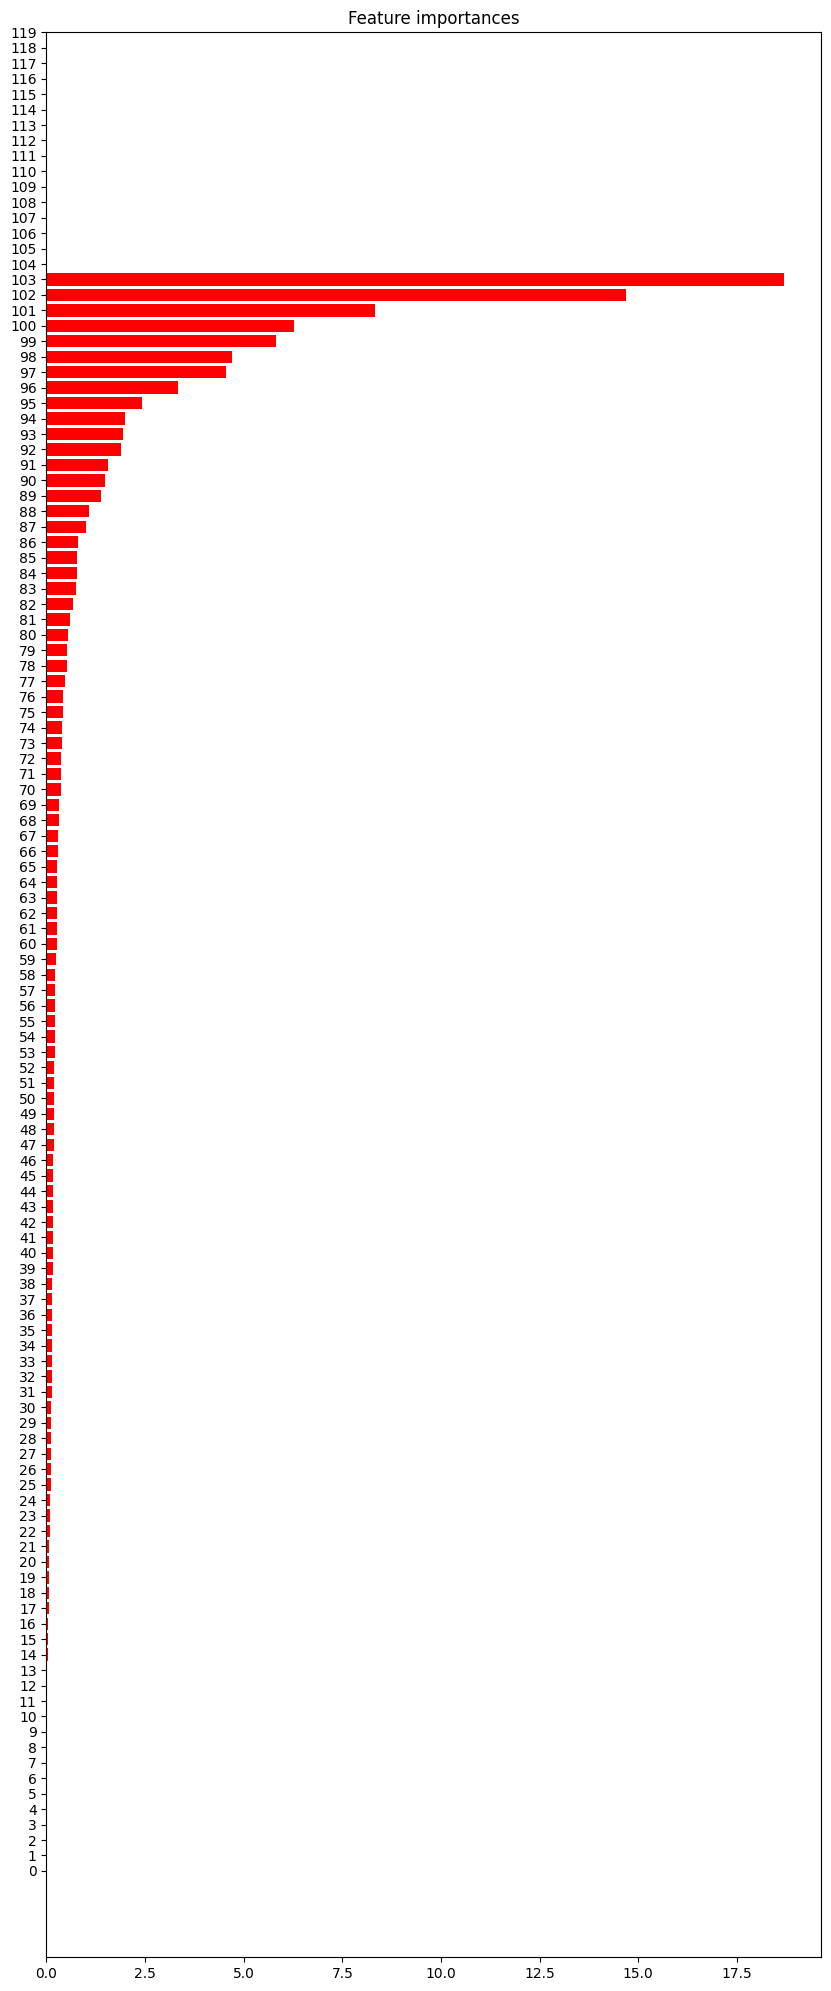

In [56]:
cat_model = CatBoostClassifier(task_type='CPU', loss_function='CrossEntropy', depth=6, 
                              iterations=1000, learning_rate=0.04)
cat_model.fit(x_train, y_train, verbose=False)
feat_imp = pd.DataFrame({'imp': cat_model.feature_importances_, 'col': num_columns})
feat_imp = feat_imp.sort_values(by=['imp'])


plt.figure(figsize=(10, 25))
plt.title("Feature importances")
plt.barh(range(X_num.shape[1]), feat_imp['imp'],
       color="r", align="center")
plt.yticks(range(X.shape[1]), feat_imp['col'])
plt.ylim([-1, X_num.shape[1]])
plt.show()

In [57]:
X_num_drop = X_num.drop(feat_imp['col'][:15], axis=1)
x_train_drop, x_test_drop = train_test_split(X_num_drop, test_size=0.3, random_state=0)
cat_model = CatBoostClassifier(task_type='CPU', loss_function='CrossEntropy', depth=6, 
                              iterations=1000, learning_rate=0.04)
cat_model.fit(x_train_drop, y_train, verbose=False)
y_cat = cat_model.predict_proba(x_test_drop)[:, 1]
print('score:', average_precision_score(y_test, y_cat))

score: 0.23583516565357782


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11115
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

ValueError: The number of FixedLocator locations (120), usually from a call to set_ticks, does not match the number of labels (104).

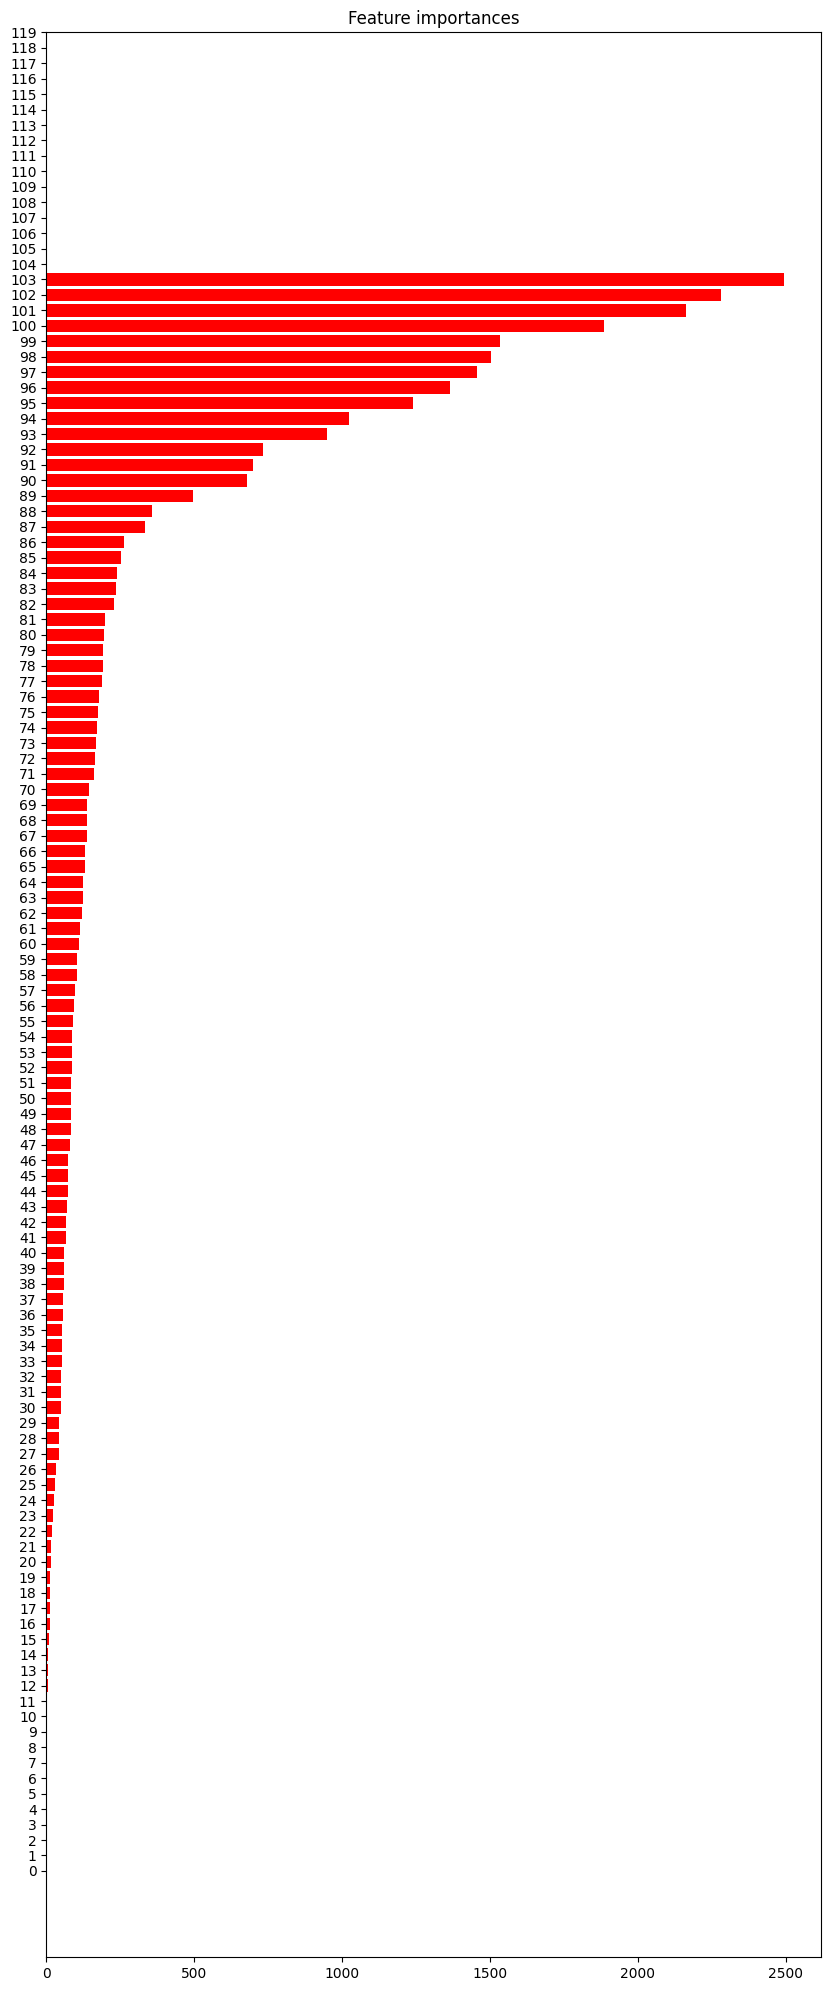

In [58]:
lgbm_model = LGBMClassifier(n_estimators=1000, metric='binary_logloss', max_depth=5, 
                            learning_rate=0.01)
lgbm_model.fit(x_train, y_train)
feat_imp_lgbm = pd.DataFrame({'imp': lgbm_model.feature_importances_, 'col': num_columns})
feat_imp_lgbm = feat_imp_lgbm.sort_values(by=['imp'])
plt.figure(figsize=(10, 25))
plt.title("Feature importances")
plt.barh(range(X_num.shape[1]), feat_imp_lgbm['imp'],
       color="r", align="center")
plt.yticks(range(X.shape[1]), feat_imp_lgbm['col'])
plt.ylim([-1, X_num.shape[1]])
plt.show()

In [59]:
X_num_drop_lgbm = X_num.drop(feat_imp_lgbm['col'][:18], axis=1)
x_train_drop_lgbm, x_test_drop_lgbm = train_test_split(X_num_drop_lgbm, test_size=0.3, random_state=0)

In [60]:
lgbm_model = LGBMClassifier(n_estimators=1000, metric='binary_logloss', max_depth=5, 
                            learning_rate=0.01)
lgbm_model.fit(x_train_drop_lgbm, y_train)
y_lgbm = lgbm_model.predict_proba(x_test_drop_lgbm)[:, 1]
print('score:', average_precision_score(y_test, y_lgbm))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10780
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth